In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
pip install ipykernel


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Projects\DeepFake_Tumor\Detection-of-Tumor-Manipulation-in-MRI-Scans\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
python -m ipykernel install --user --name=deepfake_venv --display-name "Python (Deepfake Venv)"

SyntaxError: invalid syntax. Perhaps you forgot a comma? (408055947.py, line 1)

In [5]:
import sys
print(sys.executable)

c:\Projects\DeepFake_Tumor\Detection-of-Tumor-Manipulation-in-MRI-Scans\venv\Scripts\python.exe


In [6]:
import sys
print(sys.executable)

c:\Projects\DeepFake_Tumor\Detection-of-Tumor-Manipulation-in-MRI-Scans\venv\Scripts\python.exe


In [12]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm

RAW_PATH = "Dataset/Raw"
PROCESSED_PATH = "Dataset/Processed"

tumor_classes = ["glioma", "meningioma", "pituitary"]
non_tumor_class = "notumor"


def extract_center_patch(img):
    h, w = img.shape[:2]
    size = 80   # fixed size for stability

    cx, cy = w // 2, h // 2
    x1 = cx - size // 2
    y1 = cy - size // 2

    patch = img[y1:y1+size, x1:x1+size]
    mask = 255 * np.ones(patch.shape[:2], dtype=np.uint8)

    return patch, mask


def generate_deepfake(split):
    print(f"\nGenerating {split} set...")

    raw_split = os.path.join(RAW_PATH, split)
    processed_split = os.path.join(PROCESSED_PATH, split.lower())

    real_dir = os.path.join(processed_split, "real")
    fake_dir = os.path.join(processed_split, "manipulated")

    os.makedirs(real_dir, exist_ok=True)
    os.makedirs(fake_dir, exist_ok=True)

    tumor_images = []
    for cls in tumor_classes:
        cls_path = os.path.join(raw_split, cls)
        for f in os.listdir(cls_path):
            tumor_images.append(os.path.join(cls_path, f))

    non_tumor_path = os.path.join(raw_split, non_tumor_class)
    non_tumor_files = os.listdir(non_tumor_path)

    for i in tqdm(range(len(non_tumor_files))):
        healthy_img = cv2.imread(os.path.join(non_tumor_path, non_tumor_files[i]))
        tumor_img = cv2.imread(random.choice(tumor_images))

        if healthy_img is None or tumor_img is None:
            continue

        healthy_img = cv2.resize(healthy_img, (224, 224))
        tumor_img = cv2.resize(tumor_img, (224, 224))

        patch, mask = extract_center_patch(tumor_img)

        center = (random.randint(60, 160), random.randint(60, 160))

        deepfake = cv2.seamlessClone(patch, healthy_img, mask, center, cv2.NORMAL_CLONE)

        cv2.imwrite(os.path.join(real_dir, f"real_{i}.jpg"), healthy_img)
        cv2.imwrite(os.path.join(fake_dir, f"fake_{i}.jpg"), deepfake)

    print(f"{split} generation complete.")

In [13]:
generate_deepfake("Training")
generate_deepfake("Testing")


Generating Training set...


100%|██████████| 1400/1400 [00:41<00:00, 33.42it/s]


Training generation complete.

Generating Testing set...


100%|██████████| 400/400 [00:10<00:00, 37.29it/s]

Testing generation complete.


In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dir = "Dataset/Processed/training"
test_dir = "Dataset/Processed/testing"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

print(train_dataset.classes)

['manipulated', 'real']


In [8]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)

Using Device: cuda


In [11]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [12]:
train_dir = "Dataset/Processed/training"
test_dir = "Dataset/Processed/testing"

train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

print("Classes:", train_dataset.classes)

Classes: ['manipulated', 'real']


In [13]:
model = models.resnet18(weights="IMAGENET1K_V1")

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)

print("\nPHASE 1: Training classifier head")


PHASE 1: Training classifier head


In [14]:
for epoch in range(5):
    model.train()
    correct = 0
    total = 0
    running_loss = 0

    print(f"\nEpoch [{epoch+1}/5]")

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print("Loss:", running_loss / len(train_loader))
    print("Train Accuracy:", 100 * correct / total)


Epoch [1/5]


100%|██████████| 350/350 [00:17<00:00, 20.24it/s]


Loss: 0.5751596368210656
Train Accuracy: 69.0

Epoch [2/5]


100%|██████████| 350/350 [00:12<00:00, 26.98it/s]


Loss: 0.5187545452799116
Train Accuracy: 74.60714285714286

Epoch [3/5]


100%|██████████| 350/350 [00:12<00:00, 29.11it/s]


Loss: 0.45688428344471116
Train Accuracy: 78.0

Epoch [4/5]


100%|██████████| 350/350 [00:12<00:00, 28.62it/s]


Loss: 0.4547274281510285
Train Accuracy: 78.64285714285714

Epoch [5/5]


100%|██████████| 350/350 [00:12<00:00, 27.97it/s]

Loss: 0.4329019460082054
Train Accuracy: 80.78571428571429


In [15]:
# Unfreeze everything
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

print("\nPHASE 2: Fine-tuning full model")


PHASE 2: Fine-tuning full model


In [16]:
for epoch in range(10):
    model.train()
    correct = 0
    total = 0
    running_loss = 0

    print(f"\nEpoch [{epoch+1}/10]")

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print("Loss:", running_loss / len(train_loader))
    print("Train Accuracy:", 100 * correct / total)


Epoch [1/10]


100%|██████████| 350/350 [00:21<00:00, 16.22it/s]


Loss: 0.30468023392371835
Train Accuracy: 88.5

Epoch [2/10]


100%|██████████| 350/350 [00:20<00:00, 17.24it/s]


Loss: 0.1285106645484588
Train Accuracy: 95.67857142857143

Epoch [3/10]


100%|██████████| 350/350 [00:21<00:00, 16.03it/s]


Loss: 0.10144435184026536
Train Accuracy: 96.92857142857143

Epoch [4/10]


100%|██████████| 350/350 [00:22<00:00, 15.77it/s]


Loss: 0.06872560511135296
Train Accuracy: 97.96428571428571

Epoch [5/10]


100%|██████████| 350/350 [00:21<00:00, 16.14it/s]


Loss: 0.06254254167067952
Train Accuracy: 98.03571428571429

Epoch [6/10]


100%|██████████| 350/350 [00:21<00:00, 16.00it/s]


Loss: 0.057300514051624174
Train Accuracy: 98.35714285714286

Epoch [7/10]


100%|██████████| 350/350 [00:21<00:00, 16.17it/s]


Loss: 0.044940400819759814
Train Accuracy: 98.57142857142857

Epoch [8/10]


100%|██████████| 350/350 [00:21<00:00, 16.14it/s]


Loss: 0.03577286473974319
Train Accuracy: 98.78571428571429

Epoch [9/10]


100%|██████████| 350/350 [00:21<00:00, 16.21it/s]


Loss: 0.0412394151821666
Train Accuracy: 98.53571428571429

Epoch [10/10]


100%|██████████| 350/350 [00:21<00:00, 16.24it/s]

Loss: 0.03290750591691384
Train Accuracy: 99.25


In [18]:
torch.save(model.state_dict(), "final_deepfake_model.pth")
print("Model saved successfully.")

Model saved successfully.


In [17]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

from sklearn.metrics import confusion_matrix, classification_report

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


Confusion Matrix:
[[381  19]
 [  0 400]]

Classification Report:
              precision    recall  f1-score   support

 manipulated       1.00      0.95      0.98       400
        real       0.95      1.00      0.98       400

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



In [20]:
import matplotlib.pyplot as plt
import numpy as np

In [21]:
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

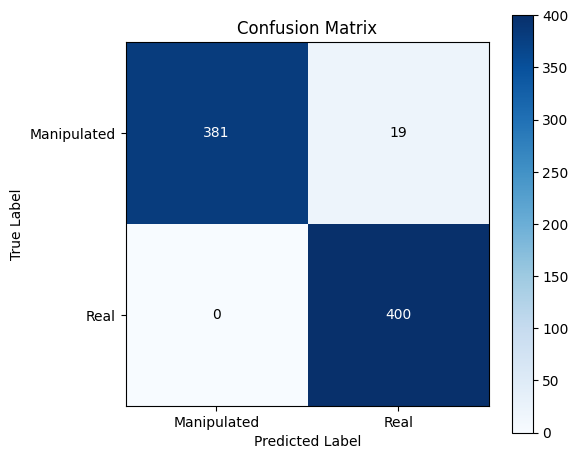

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Recompute confusion matrix from predictions
cm = confusion_matrix(all_labels, all_preds)

classes = ["Manipulated", "Real"]

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

plt.xticks(np.arange(len(classes)), classes)
plt.yticks(np.arange(len(classes)), classes)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Write values inside boxes
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black")

plt.tight_layout()
plt.show()

In [25]:
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [22]:
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="IMAGENET1K_V1")

for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [17]:
from tqdm import tqdm

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print("Loss:", running_loss / len(train_loader))
    print("Train Accuracy:", 100 * correct / total)


Epoch [1/20]


100%|██████████| 350/350 [00:43<00:00,  7.96it/s]


Loss: 0.24918491206531013
Train Accuracy: 89.89285714285714

Epoch [2/20]


100%|██████████| 350/350 [00:16<00:00, 21.83it/s]


Loss: 0.10228030347531396
Train Accuracy: 97.03571428571429

Epoch [3/20]


100%|██████████| 350/350 [00:16<00:00, 21.62it/s]


Loss: 0.06059946153878367
Train Accuracy: 98.17857142857143

Epoch [4/20]


100%|██████████| 350/350 [00:16<00:00, 21.51it/s]


Loss: 0.041881769672368785
Train Accuracy: 98.82142857142857

Epoch [5/20]


100%|██████████| 350/350 [00:16<00:00, 21.40it/s]


Loss: 0.035091691223954384
Train Accuracy: 99.17857142857143

Epoch [6/20]


100%|██████████| 350/350 [00:16<00:00, 21.45it/s]


Loss: 0.018670354930301464
Train Accuracy: 99.53571428571429

Epoch [7/20]


100%|██████████| 350/350 [00:16<00:00, 21.33it/s]


Loss: 0.04830601323163137
Train Accuracy: 98.71428571428571

Epoch [8/20]


100%|██████████| 350/350 [00:16<00:00, 21.33it/s]


Loss: 0.05986867135773147
Train Accuracy: 98.21428571428571

Epoch [9/20]


100%|██████████| 350/350 [00:16<00:00, 21.30it/s]


Loss: 0.022347724057617598
Train Accuracy: 99.46428571428571

Epoch [10/20]


100%|██████████| 350/350 [00:16<00:00, 21.08it/s]


Loss: 0.007375978840282187
Train Accuracy: 99.89285714285714

Epoch [11/20]


100%|██████████| 350/350 [00:16<00:00, 21.18it/s]


Loss: 0.029923655238567985
Train Accuracy: 99.39285714285714

Epoch [12/20]


100%|██████████| 350/350 [00:16<00:00, 21.32it/s]


Loss: 0.014461321548276049
Train Accuracy: 99.5

Epoch [13/20]


100%|██████████| 350/350 [00:16<00:00, 21.26it/s]


Loss: 0.03142180979642684
Train Accuracy: 98.92857142857143

Epoch [14/20]


100%|██████████| 350/350 [00:16<00:00, 21.24it/s]


Loss: 0.020999879073434775
Train Accuracy: 99.39285714285714

Epoch [15/20]


100%|██████████| 350/350 [00:16<00:00, 21.22it/s]


Loss: 0.024516831033189582
Train Accuracy: 99.28571428571429

Epoch [16/20]


100%|██████████| 350/350 [00:16<00:00, 21.25it/s]


Loss: 0.02101181459284687
Train Accuracy: 99.35714285714286

Epoch [17/20]


100%|██████████| 350/350 [00:16<00:00, 20.96it/s]


Loss: 0.008812312982398518
Train Accuracy: 99.82142857142857

Epoch [18/20]


100%|██████████| 350/350 [00:16<00:00, 21.16it/s]


Loss: 0.0019108798244269565
Train Accuracy: 100.0

Epoch [19/20]


100%|██████████| 350/350 [00:16<00:00, 21.11it/s]


Loss: 0.0006572118506301194
Train Accuracy: 100.0

Epoch [20/20]


100%|██████████| 350/350 [00:16<00:00, 21.21it/s]

Loss: 0.0009947870232333246
Train Accuracy: 100.0


In [1]:
torch.save(model.state_dict(), "final_deepfake_model.pth")
print("Model saved successfully.")

NameError: name 'torch' is not defined

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
